Path signatures
======

### In this tutorial we will use the [iisignature](https://github.com/bottler/iisignature) python package to compute path signature values for example data.




#### First, load packages. The iisignature package is from python so we'll need to use the Julia PyCall package to import the important functions. 

In [1]:
# Loading packages
using Plots
theme(:dark)
using DataFrames
using PyCall
using MAT
using LinearAlgebra

iisig = pyimport("iisignature")

println("Finished loading packages.")

┌ Info: Precompiling MAT [23992714-dd62-5051-b70f-ba57cb901cac]
└ @ Base loading.jl:1242


Finished loading packages.


#### Next we will make two cyclic paths called `path1` and `path2`. For simplicity, we'll create these paths by reparametrizing sin functions. Additionally, we can choose the value of `offset` to change how much `path2` lags `path1`.

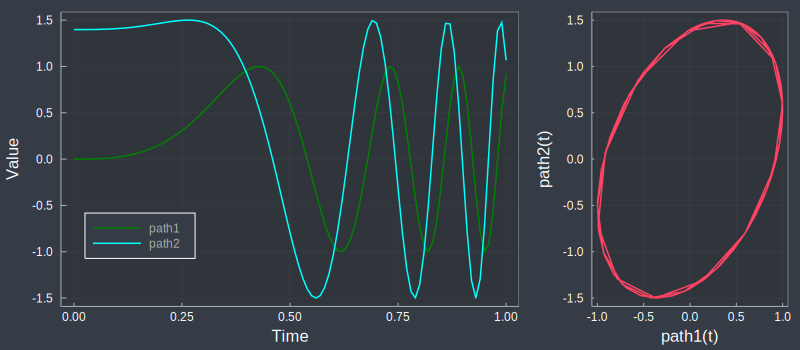

In [2]:
# Choose offset in [0,pi]
offset = 1.2

# Define x values
xVals = ((1/100)*collect(0:100)).^3

# Compute and draw paths in our first plot
path1 = sin.(20*xVals)
path2 = 1.5*sin.(20*xVals .+offset)

p1a = plot(collect(0:0.01:1),path1, c = :green, label = "path1", linewidth = 1.5)
plot!(collect(0:0.01:1),path2,c = :cyan, label = "path2", legend = :bottomleft, linewidth = 1.5)
xlabel!("Time")
ylabel!("Value")

p1b = plot(path1,path2, aspect_ratio = :equal, legend = false, linewidth = 1.5)
xlabel!("path1(t)")
ylabel!("path2(t)")

plot(p1a,p1b, layout = grid(1,2,widths = [0.7, 0.3]), size = (800,350), frame_style = :box)

#### Examine how the offset changes the area of the enclosed region
Change the `offset` variable and rerun.

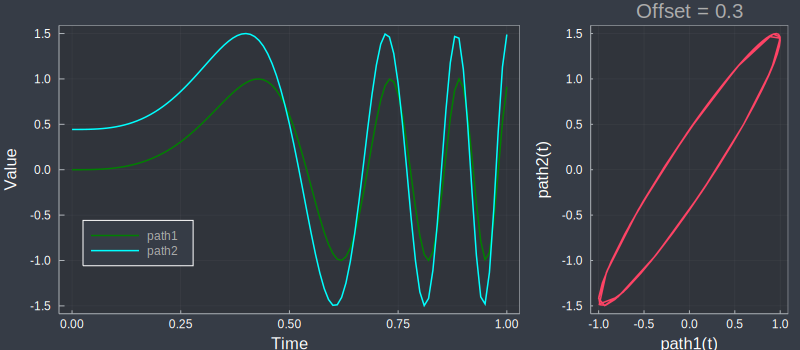

In [3]:
#### Change this variable and rerun!! ####
offset = 0.3
####---------------####

# Compute and draw paths in our first plot
path1 = sin.(20*xVals)
path2 = 1.5*sin.(20*xVals .+offset)

p2a = plot(collect(0:0.01:1),path1, c = :green, label = "path1", linewidth = 1.5)
plot!(collect(0:0.01:1),path2, c = :cyan, label = "path2", legend = :bottomleft, linewidth = 1.5)
xlabel!("Time")
ylabel!("Value")

p2b = plot(path1,path2, aspect_ratio = :equal, legend = false, linewidth = 1.5)
xlabel!("path1(t)")
ylabel!("path2(t)")
title!("Offset = $offset")

plot(p2a,p2b, layout = grid(1,2,widths = [0.7, 0.3]), size = (800,350), frame_style = :box)

#### Using path signatures to compute the signed area.

##### __Note:__ we will only show equations that we end up using in the following computations. For more on the higher levels of path signatures, please see the references included at the end of this tutorial

Next we will use the `sig` function from the iisignature package to compute the degree to which path1 leads path2. Recall the level one path signature of a path $\Gamma(t) = (\gamma_1(t), \dots, \gamma_n(t))$ for component $i$ is $S^i = \int_0^1\gamma_1'dt$, and the level two signature $S^{i,j} = \int_0^1S^i(t)\gamma_j'dt$. However, our data are discrete and we can interpret each path component as a piecewise linear function. Then a little algebra (or geometric arguments) can show that for one straight line section of the path in $[t_r,t_{r+1}]$, $$S^i_{t_r,t_{r+1}} = \gamma_i(t_{r+1}) - \gamma_i(t_r)$$ and that 
$$S^{i,j}_{t_r,t_{r+1}} = \frac{1}{2}\big(\gamma_i(t_{r+1}) - \gamma_i(t_r)\big)\big(\gamma_j(t_{r+1}) - \gamma_j(t_r)\big)$$ 

To extend to the entire piecewise linear path, we use [Chen's identity](https://www.ams.org/journals/tran/1958-089-02/S0002-9947-1958-0106258-0/) which says if $a<b<c$, then $$S_{a,b}^{i,j} = S_{a,b}^{i,j} + S_{a,b}^i S_{b,c}^j + S_{b,c}^{i,j}$$

This is how the `sig` function will calculate the signature terms. The `sig` function returns the path signature in a vector with terms $(S^1,S^2,S^{1,1}, S^{1,2}, S^{2,1}, S^{2,2}, \dots)$. From this vector we can compute the signed area with $$ A = \frac{1}{2} (S^{i,j} - S^{j,i})$$

The `sig` function takes our paths in the form of an $nPoints \times nPaths$ array. We will construct a path `Gamma` which has `path1` and `path2` as components.

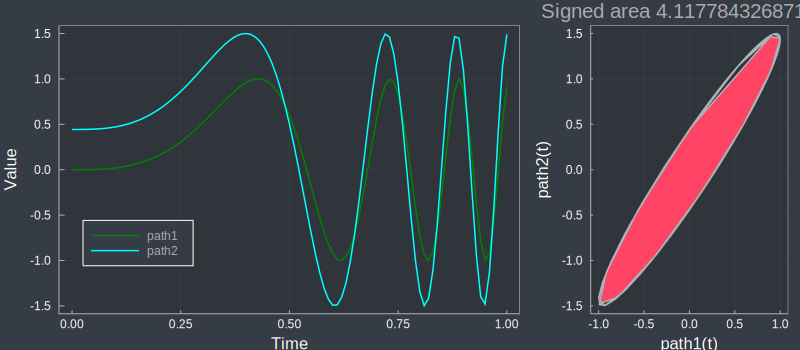

In [4]:
# Choose the final offset and make paths as before

offset = 0.3
path1 = sin.(20*xVals)
path2 = 1.5*sin.(20*xVals .+offset)

# Compute the path signature and signed area for Gamma
Gamma = [path1 path2]
signM = iisig.sig(Gamma,2)
signed_area = (0.5)*(signM[5] - signM[4])

# Plot results
p3a = plot(collect(0:0.01:1),path1, c = :green, label = "path1", linewidth = 1.5)
plot!(collect(0:0.01:1),path2,c = :cyan, label = "path2", legend = :bottomleft, linewidth = 1.5)
xlabel!("Time")
ylabel!("Value")

p3b = plot(path1,path2,aspect_ratio = :equal, legend = false, linewidth = 1.5, seriestype = :shape)
title!("Signed area $signed_area")
xlabel!("path1(t)")
ylabel!("path2(t)")

plot(p3a,p3b,layout = grid(1,2,widths = [0.7, 0.3]), size = (800,350), frame_style = :box)


#### Lead-lag relationship in data
Finally we will create some example time series and use their path signatures to find which pairs have a strong lead-lag relationship. First we will define the paths, construct our large path `GammaBig`, compute the second level path signature terms, and lastly construct a heatmap of the signed area between path pairs, `signedAreaMat`.

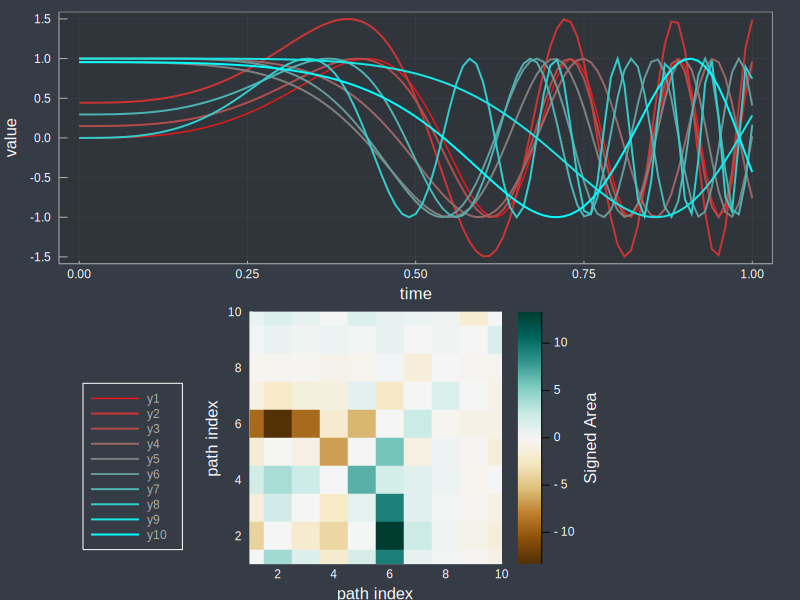

In [5]:
# Let's define eight more paths. No rhyme or reason, just some more cyclic paths with different properties.

path3 = sin.(20*xVals .+ (0.5)*offset)
path4 = cos.(15*xVals)
path5 = cos.(17*xVals.+offset)
path6 = cos.(20*xVals)
path7 = sin.(25*xVals.+offset)
path8 = sin.(40*xVals)
path9 = cos.(5*xVals)
path10 = cos.(8*xVals.+offset)

# Construct GammaBig
GammaBig = [path1 path2 path3 path4 path5 path6 path7 path8 path9 path10]

# Compute path signature and reshape into a nPaths x nPaths matrix for easier calculations later
signsVec = iisig.sig(GammaBig,2)
signsMat = reshape(signsVec[11:110],10,10)

# Calculate the signed area
signedAreaMat = zeros(size(signsMat))
for a in 1:10, b in (a+1):10    
    signedArea_ab = 0.5*(signsMat[a,b] - signsMat[b,a])
    signedAreaMat[a,b] = signedArea_ab
    signedArea_ba = 0.5*(signsMat[b,a] - signsMat[a,b])
    signedAreaMat[b,a] = signedArea_ba
end

p4a = plot(collect(0:0.01:1),GammaBig[:,1], c = RGB(0.9,0.1,0.1), linewidth = 1.5)
for path_n in collect(2:10)
        plot!(collect(0:0.01:1),GammaBig[:,path_n], c = RGB(1-(path_n/10),(path_n/10),(path_n/10)),linewidth = 2, legend = :left)
end
xlabel!("time")
ylabel!("value")

p4b = heatmap(signedAreaMat,aspect_ratio = 1, c = :BrBG, colorbar_title = "Signed Area", xlim = (1,10), ylim = (1,10))
xlabel!("path index")
ylabel!("path index")

plot(p4a,p4b,layout = grid(2,1,widths = [1, 0.3]), size = (800,600), frame_style = :box)

#### Adding noise...
How do the results change with adding random noise? For this last section we will add uniform random noise to our paths and recompute the signed area. Try changing the value of `noiseScalar` to examine the effect of noise on the lead matrix (`signedAreaMat`).

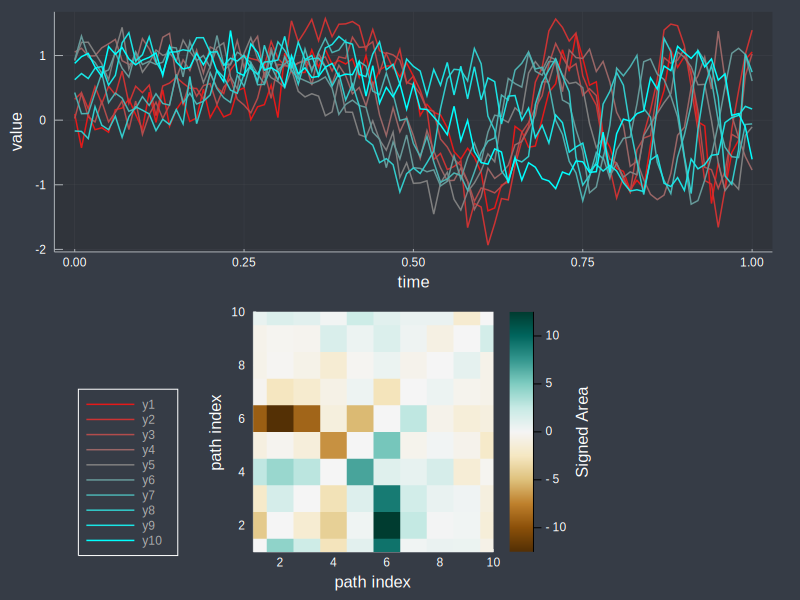

In [6]:
# Change the value of noiseScalar to adjust influence of noise
noiseScalar = 0.2

# Add noise
GammaBigNoise = GammaBig.+ noiseScalar*randn(size(GammaBig))

# Compute path signature and signed area
signsVecNoise = iisig.sig(GammaBigNoise,2)
signsMatNoise = reshape(signsVecNoise[11:110],10,10)
signedAreaMatNoise = zeros(size(signsMatNoise))
for a in 1:10, b in (a+1):10    
    signedArea_ab = 0.5*(signsMatNoise[a,b] - signsMatNoise[b,a])
    signedAreaMatNoise[a,b] = signedArea_ab
    signedArea_ba = 0.5*(signsMatNoise[b,a] - signsMatNoise[a,b])
    signedAreaMatNoise[b,a] = signedArea_ba
end

# Plot!
p4a = plot(collect(0:0.01:1),GammaBigNoise[:,1], c = RGB(0.9,0.1,0.1), linewidth = 1.5)
for path_n in collect(2:10)
        plot!(collect(0:0.01:1),GammaBigNoise[:,path_n], c = RGB(1-(path_n/10),(path_n/10),(path_n/10)),linewidth = 1.5)
end
xlabel!("time")
ylabel!("value")

p4b = heatmap(signedAreaMatNoise,aspect_ratio = 1, color = :BrBG, colorbar_title = "Signed Area", xlim = (1,10), ylim = (1,10))
xlabel!("path index")
ylabel!("path index")


plot(p4a,p4b,layout = grid(2,1,widths = [1, 0.3]), size = (800,600), legend = :left)


### More references

Yang, Weixin, et al. ["Leveraging the path signature for skeleton-based human action recognition."](https://arxiv.org/pdf/1707.03993.pdf) arXiv preprint arXiv:1707.03993 (2017).

Giusti, Chad, and Darrick Lee. ["Path Space Cochains and Population Time Series Analysis."](https://arxiv.org/pdf/1811.03558.pdf) arXiv preprint arXiv:1811.03558 (2018).

Reizenstein, Jeremy, and Benjamin Graham. ["The iisignature library: efficient calculation of iterated-integral signatures and log signatures."](https://arxiv.org/pdf/1802.08252.pdf) arXiv preprint arXiv:1802.08252 (2018).

Zimmerman, Benjamin J., et al. ["Dissociating tinnitus patients from healthy controls using resting-state cyclicity analysis and clustering."](https://www.mitpressjournals.org/doi/full/10.1162/netn_a_00053) Network Neuroscience 3.1 (2018): 67-89.

Chen, K. T. ["Integration of paths; a faithful representation of paths by non-commutative formal power series."](https://books.google.com/books?hl=en&lr=&id=3IKhzHBp4YYC&oi=fnd&pg=PA83&dq=Integration+of+paths--A+faithful+representation+of+paths+by+noncommutative+formal+power+series&ots=FWMhjD7ko6&sig=6oPO8SpOjIbMYuo6WYm9c-yEeKU#v=onepage&q=Integration%20of%20paths--A%20faithful%20representation%20of%20paths%20by%20noncommutative%20formal%20power%20series&f=false) (1958): 395-407.